In [1]:
import pickle

from sklearn.cluster import AgglomerativeClustering

import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import metrics

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
with open('..\\data\\processed\\X_scaled.pickle', 'rb') as f:
        X = pickle.load(f)

In [3]:
clustering = AgglomerativeClustering(n_clusters=2,
                                     affinity='euclidean', 
                                     memory=None, 
                                     connectivity=None, 
                                     compute_full_tree='auto', 
                                     linkage='ward', 
                                     distance_threshold=None).fit(X)
labels = clustering.labels_

# Дендрограмма

In [4]:
N = len(pd.unique(pd.Series(labels)))

In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

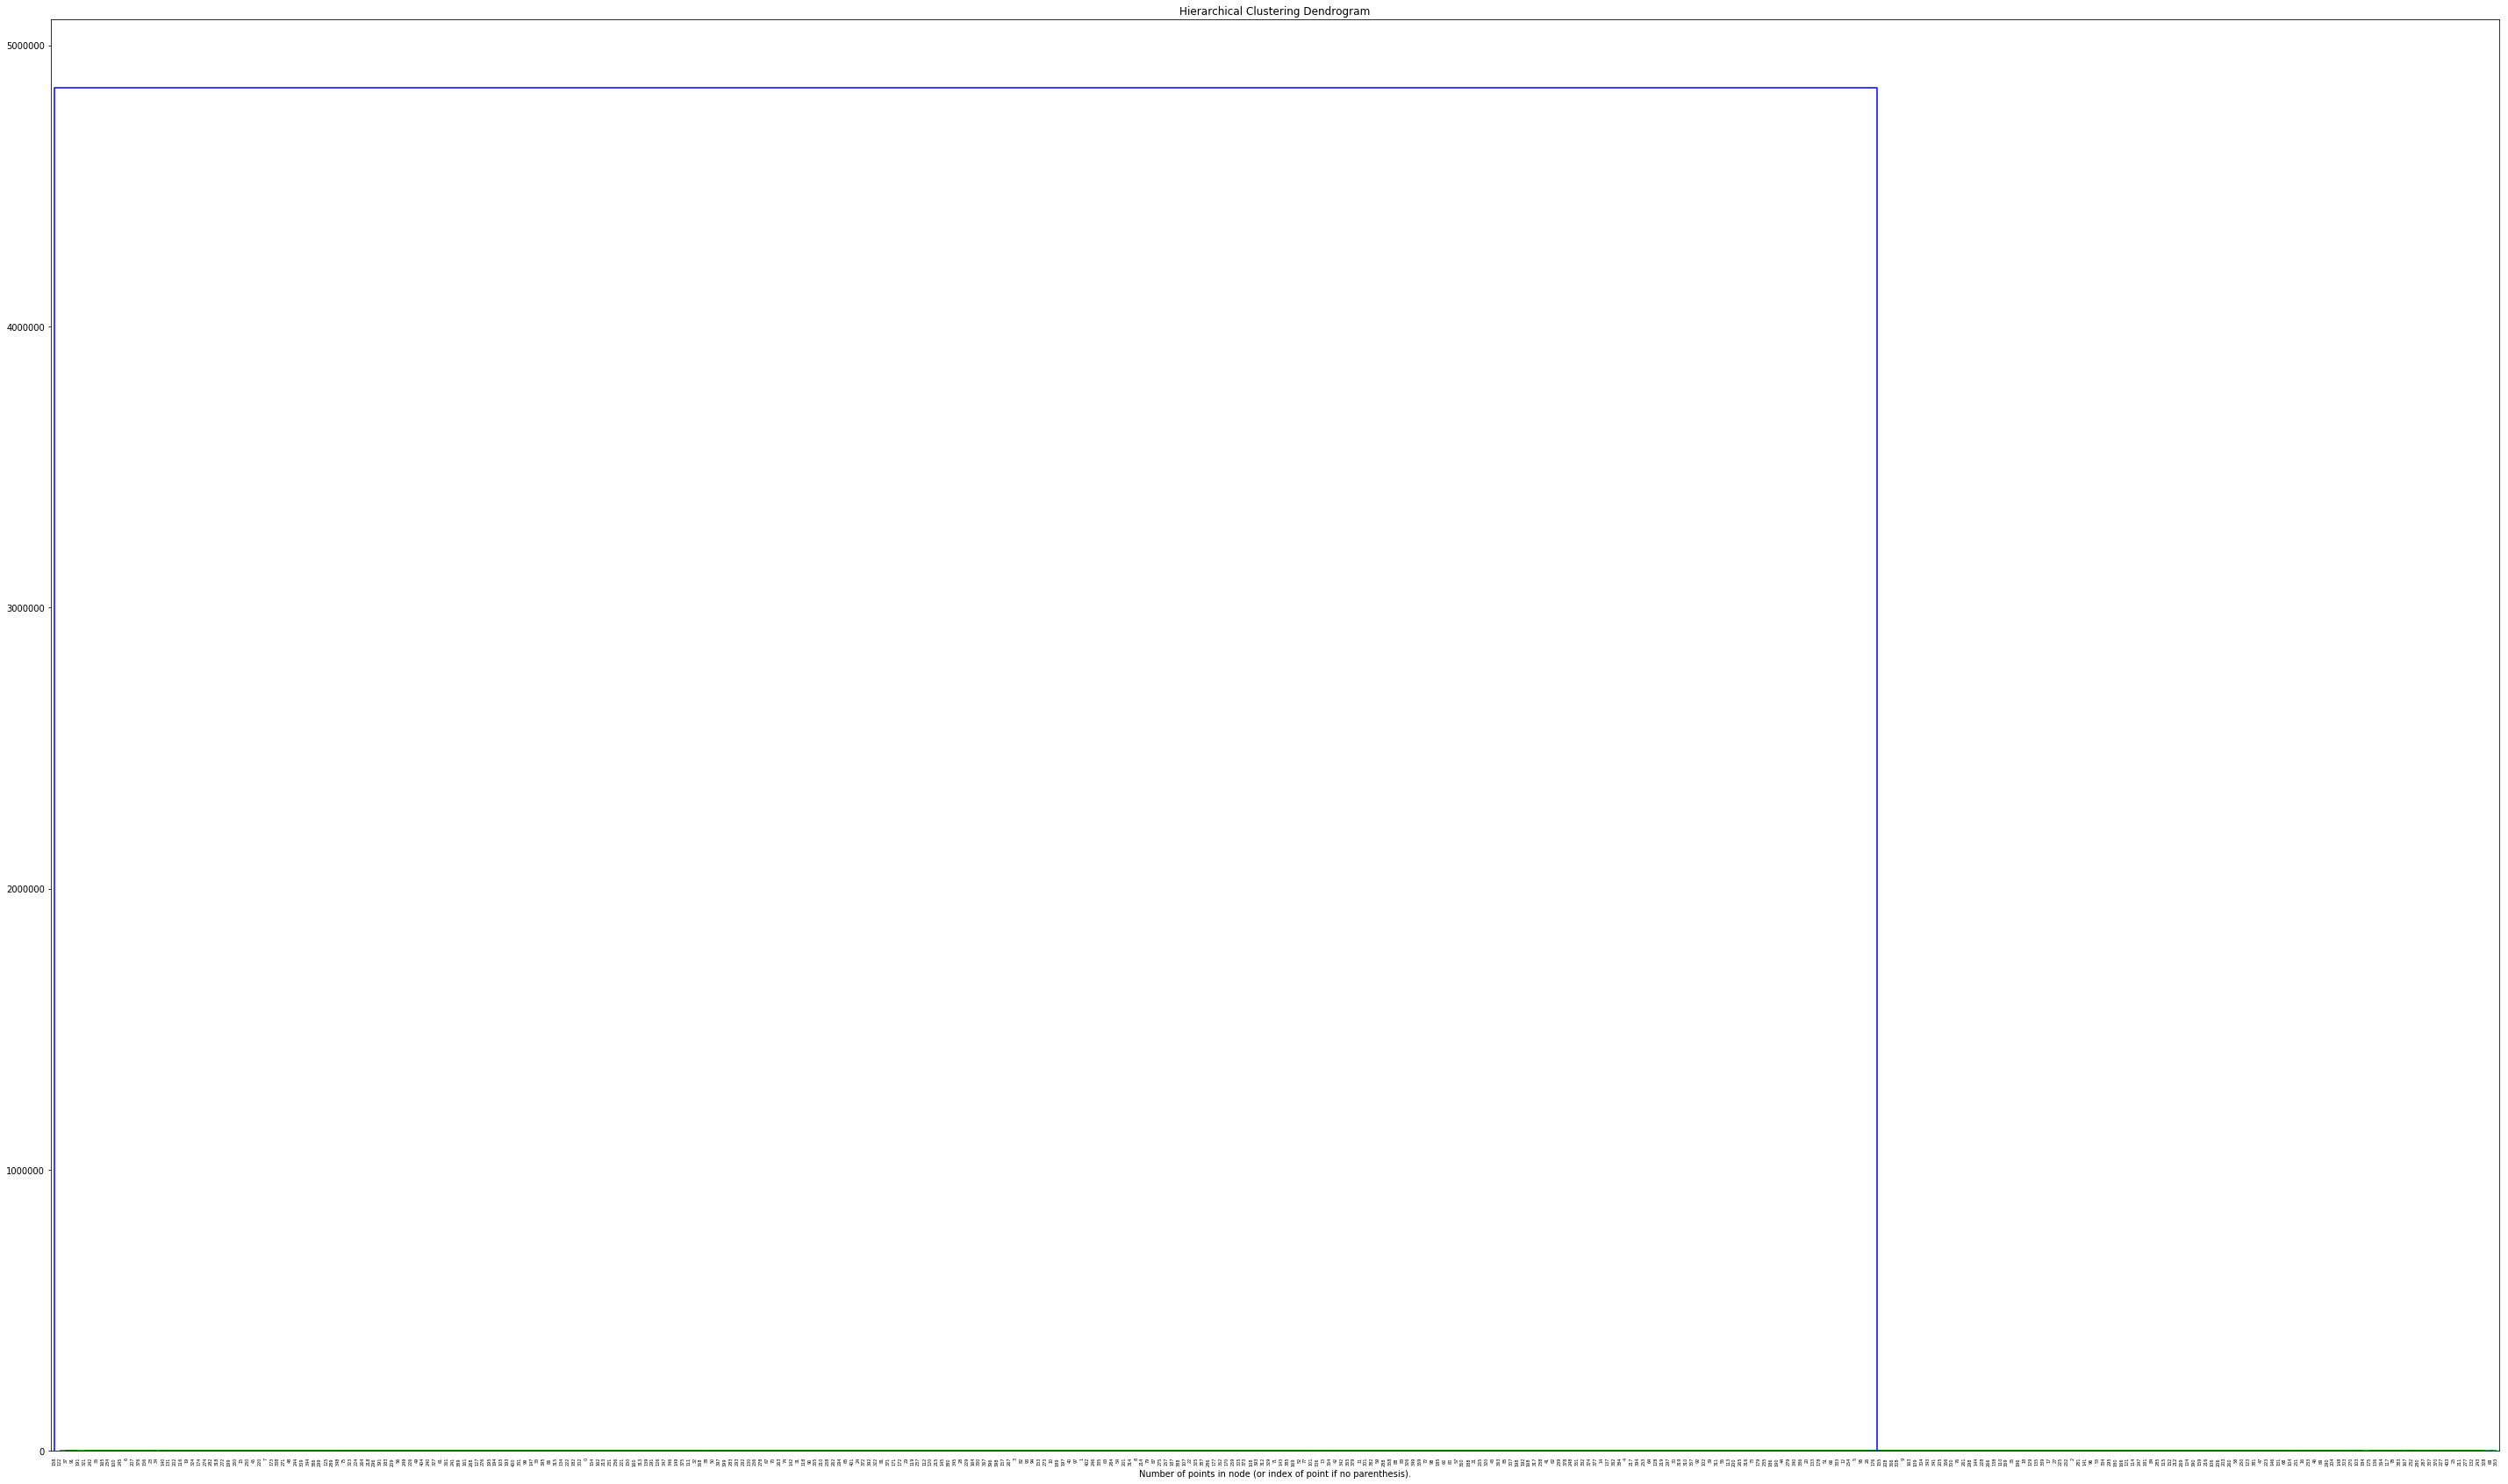

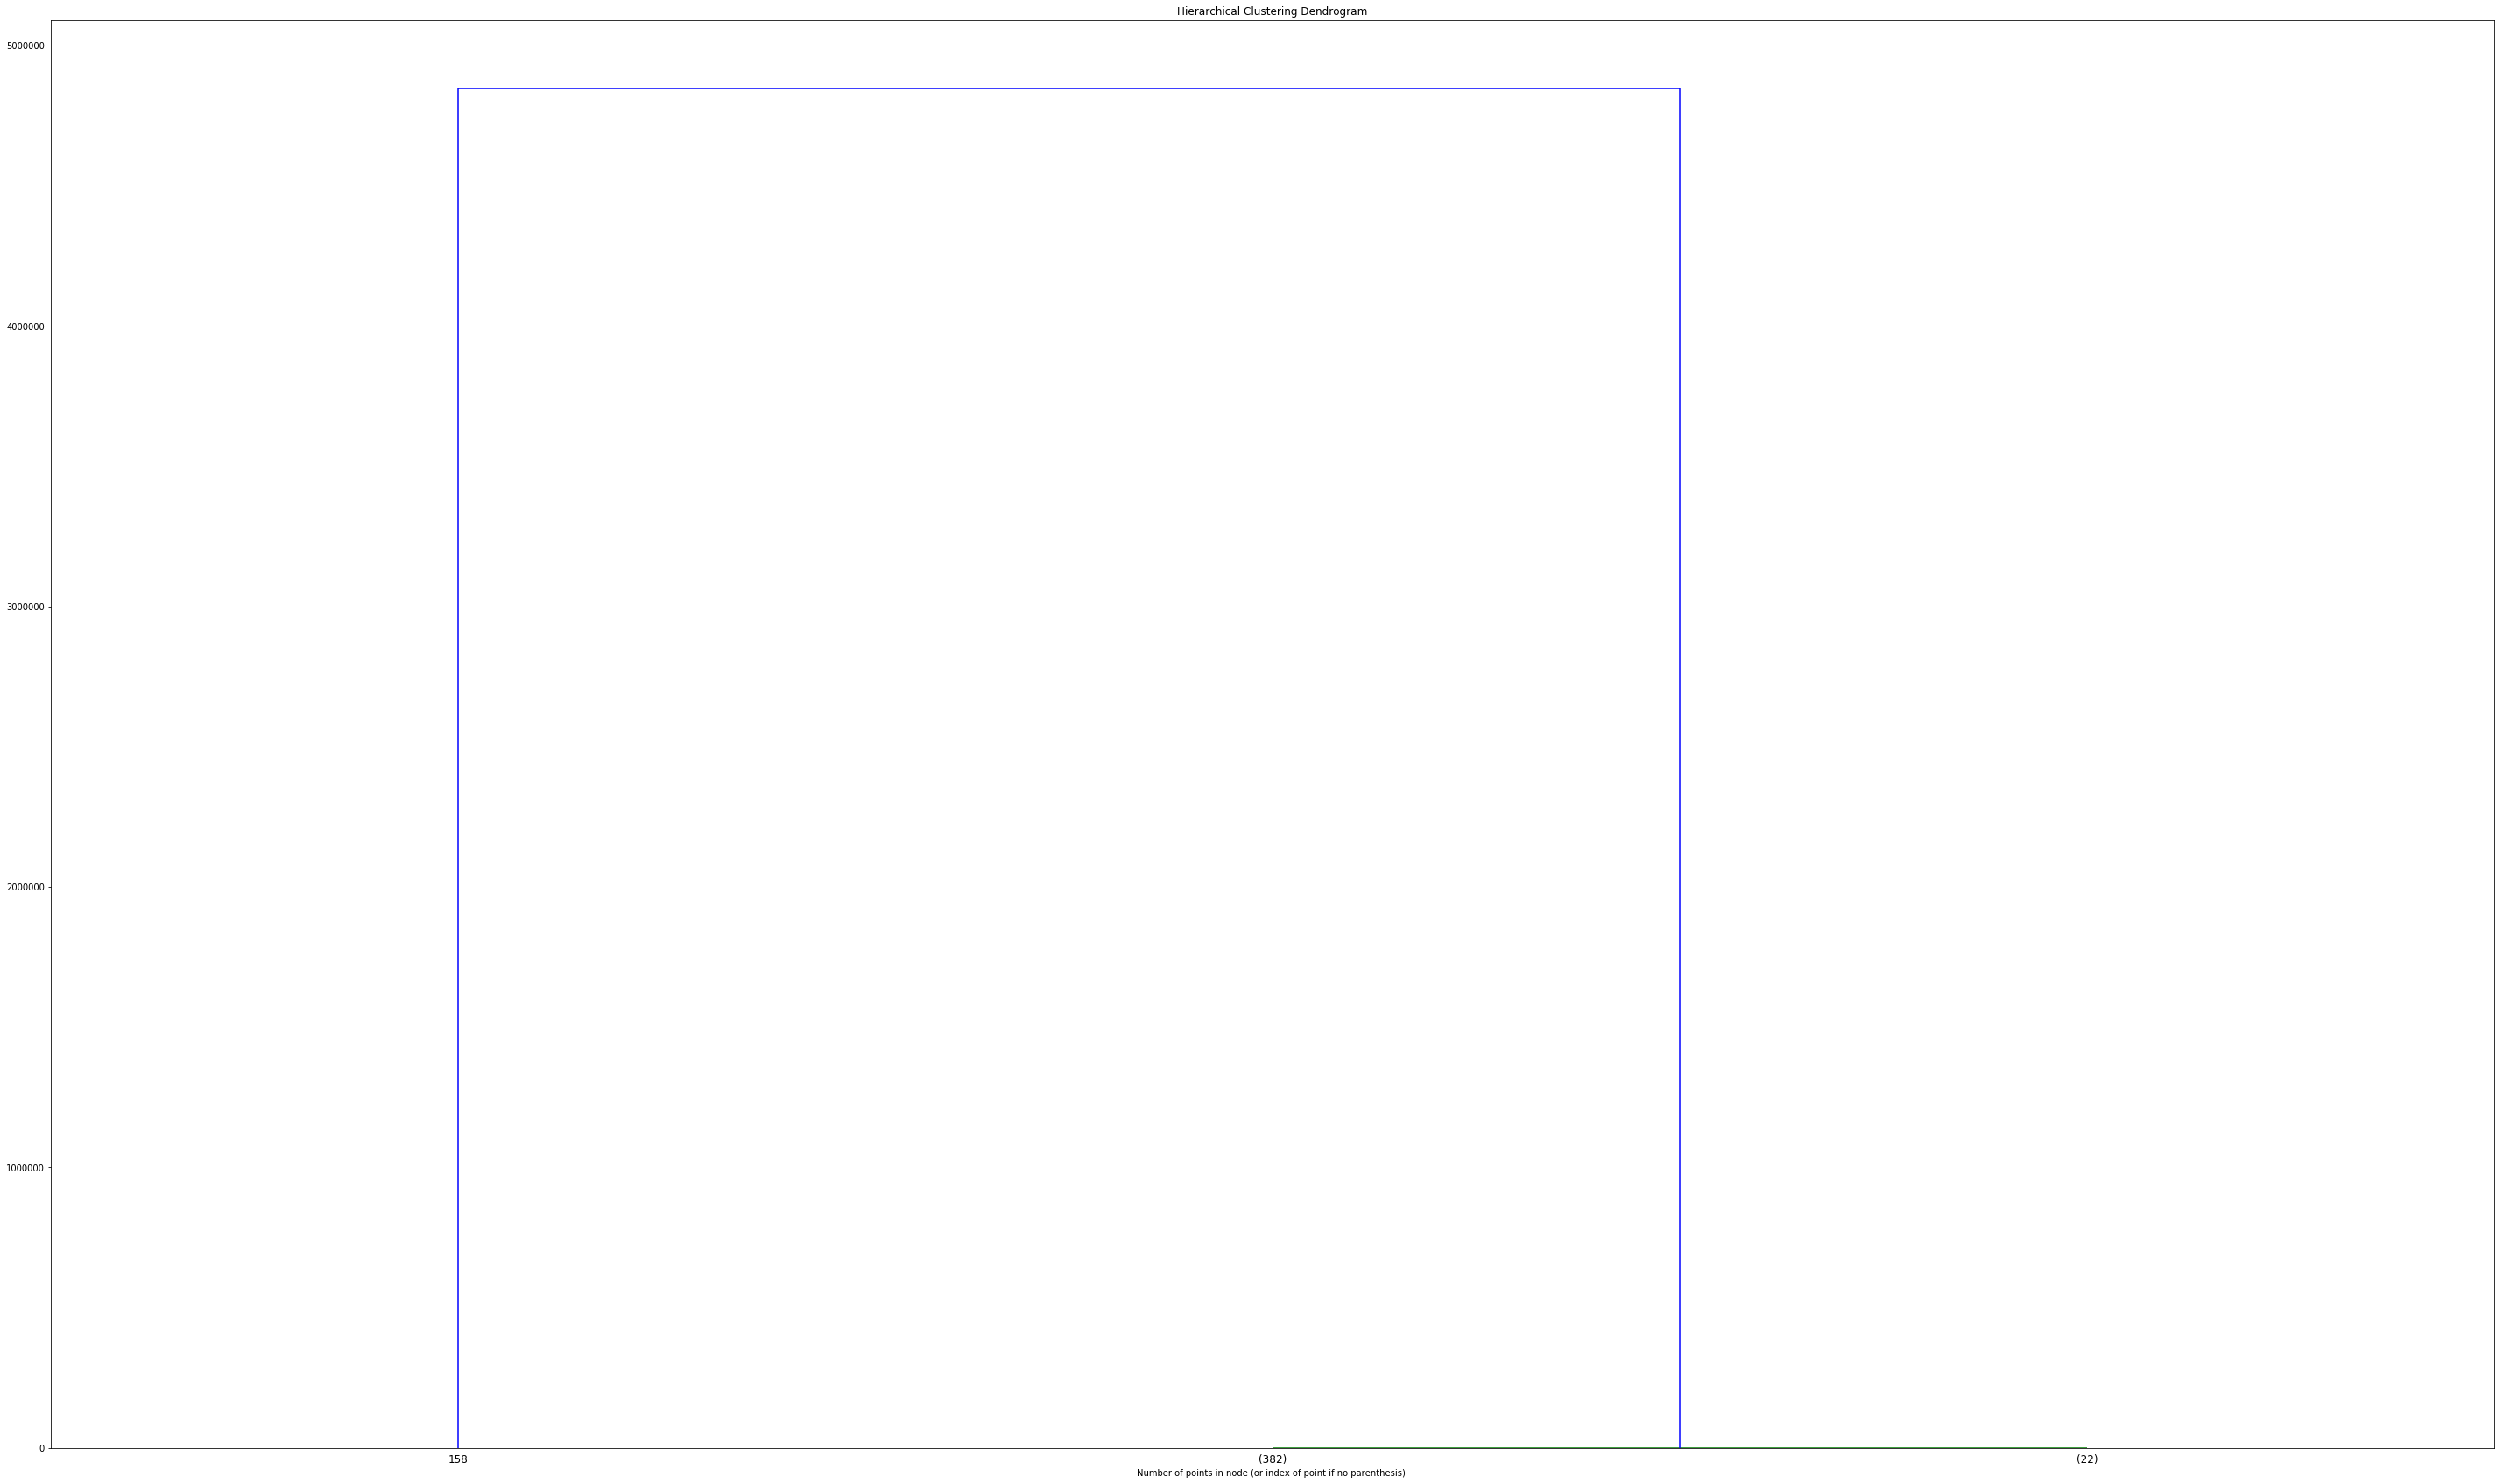

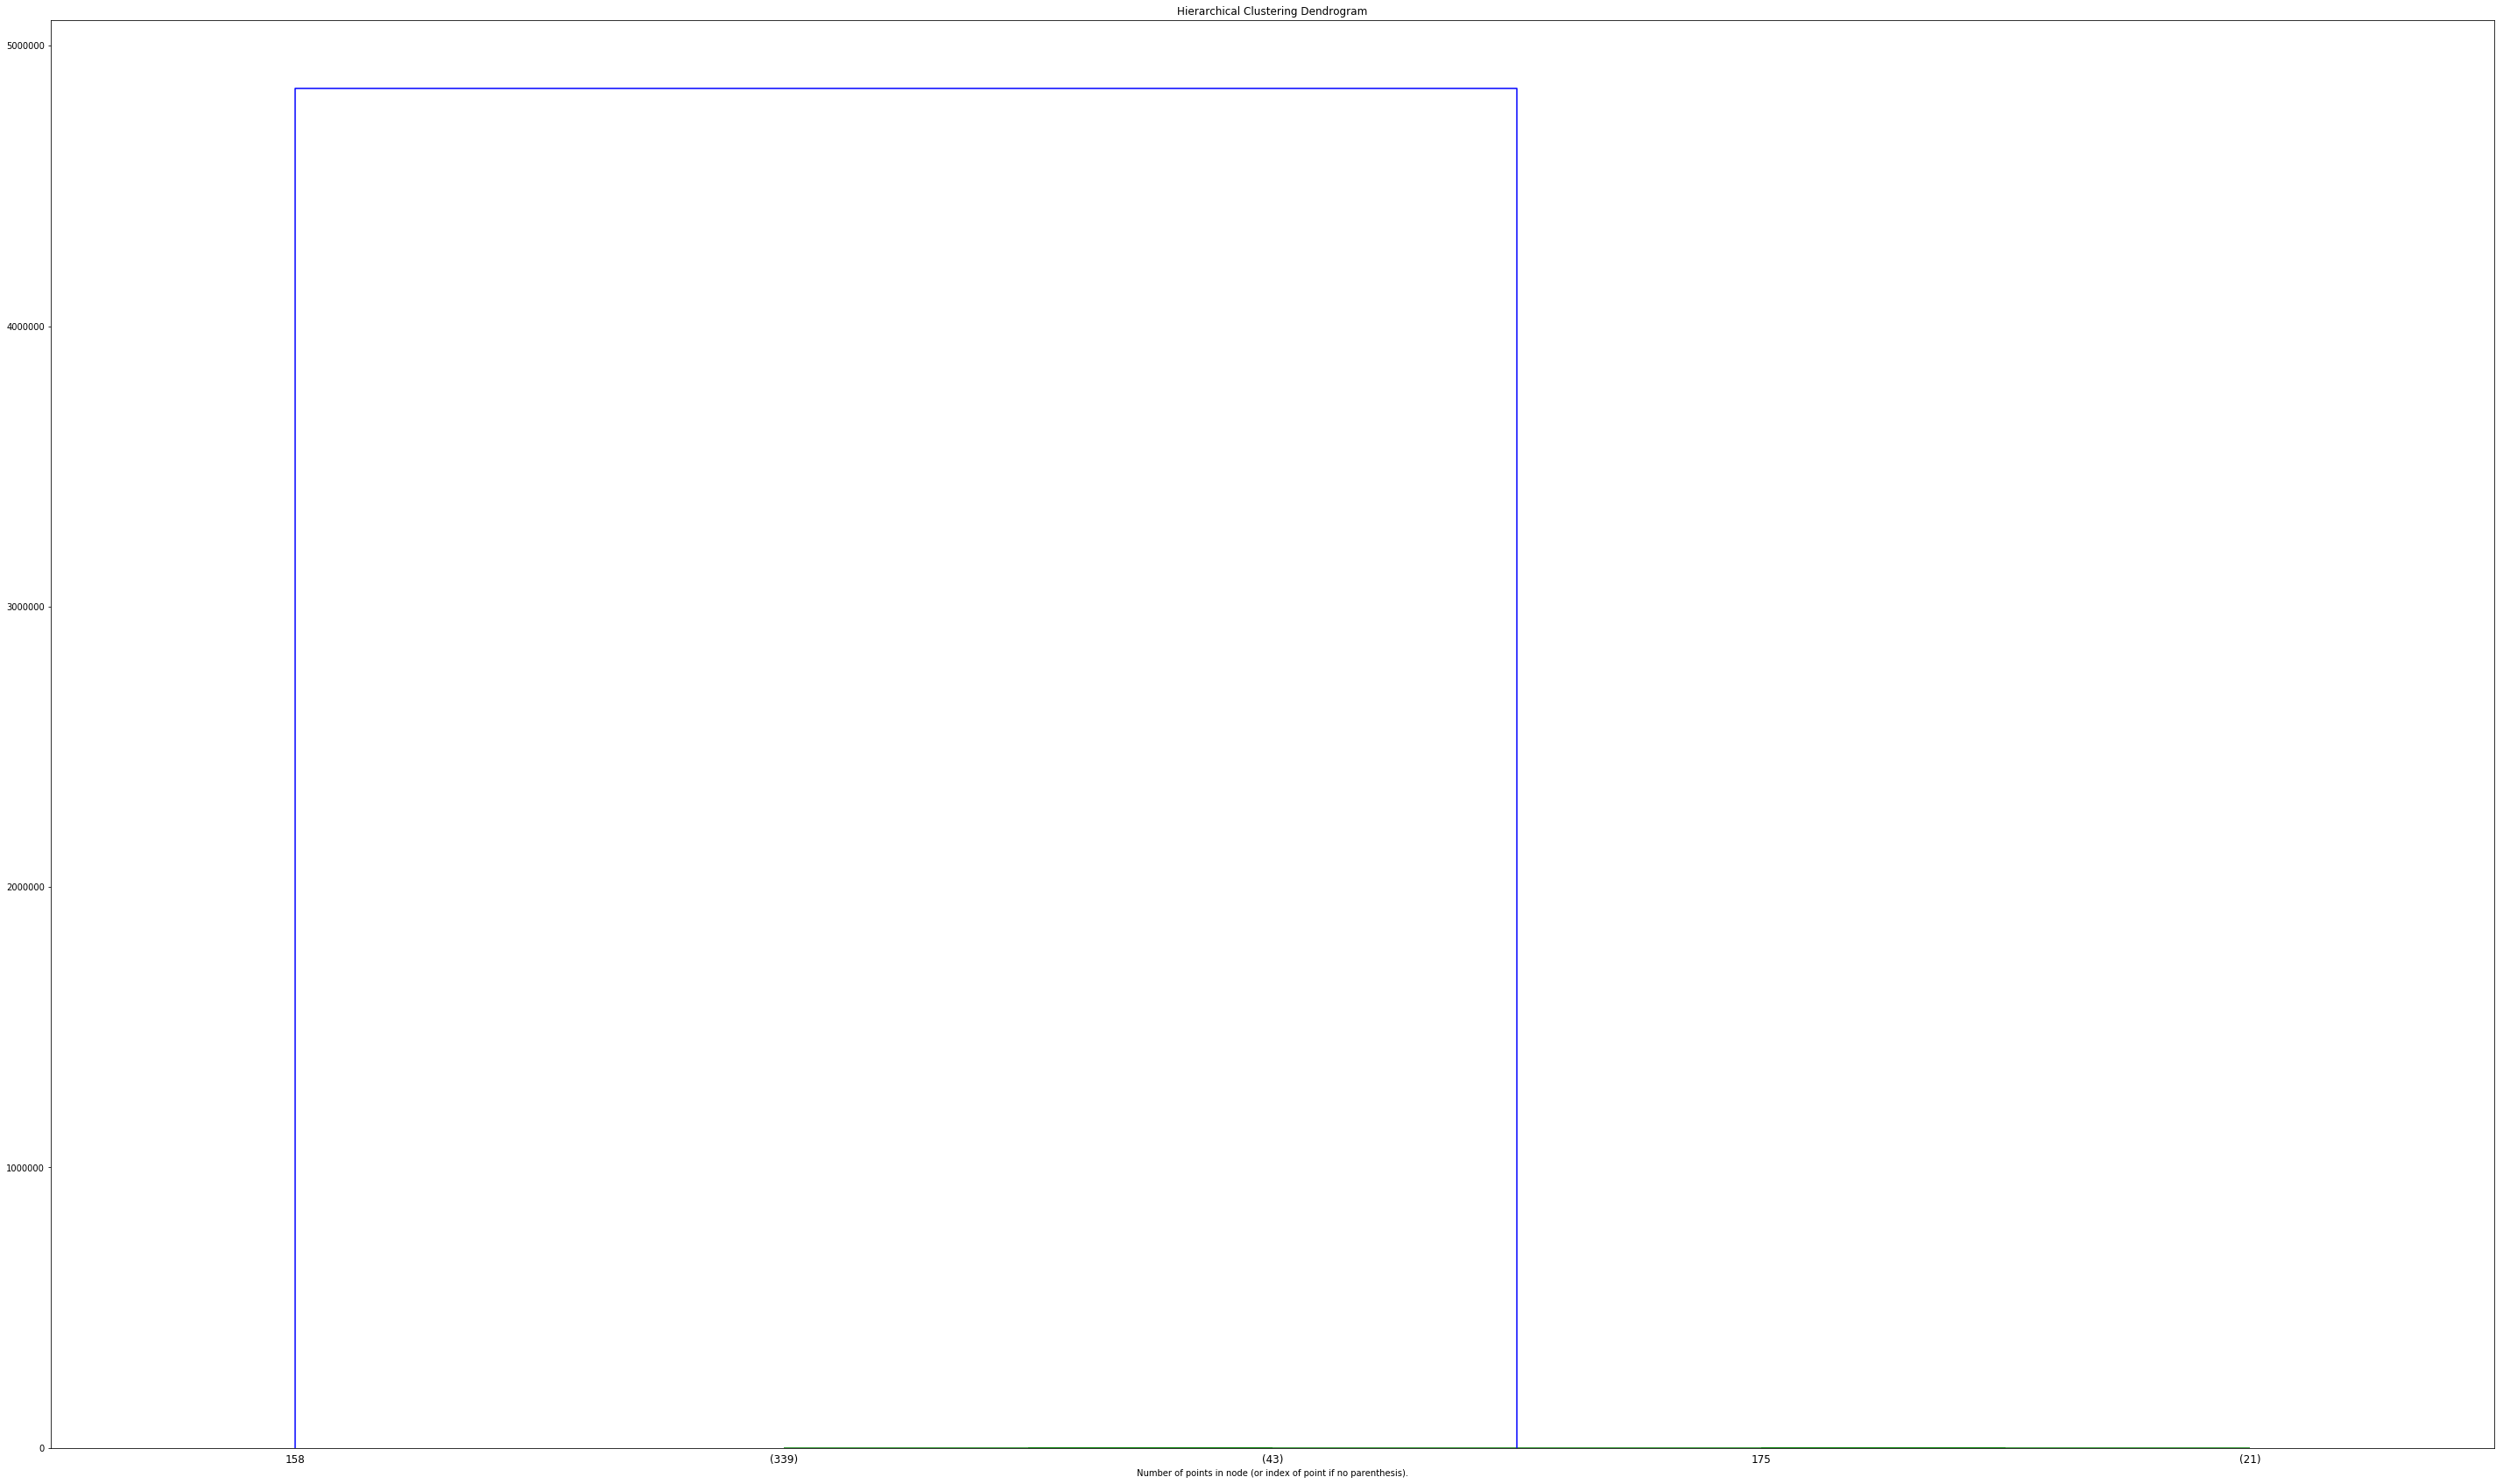

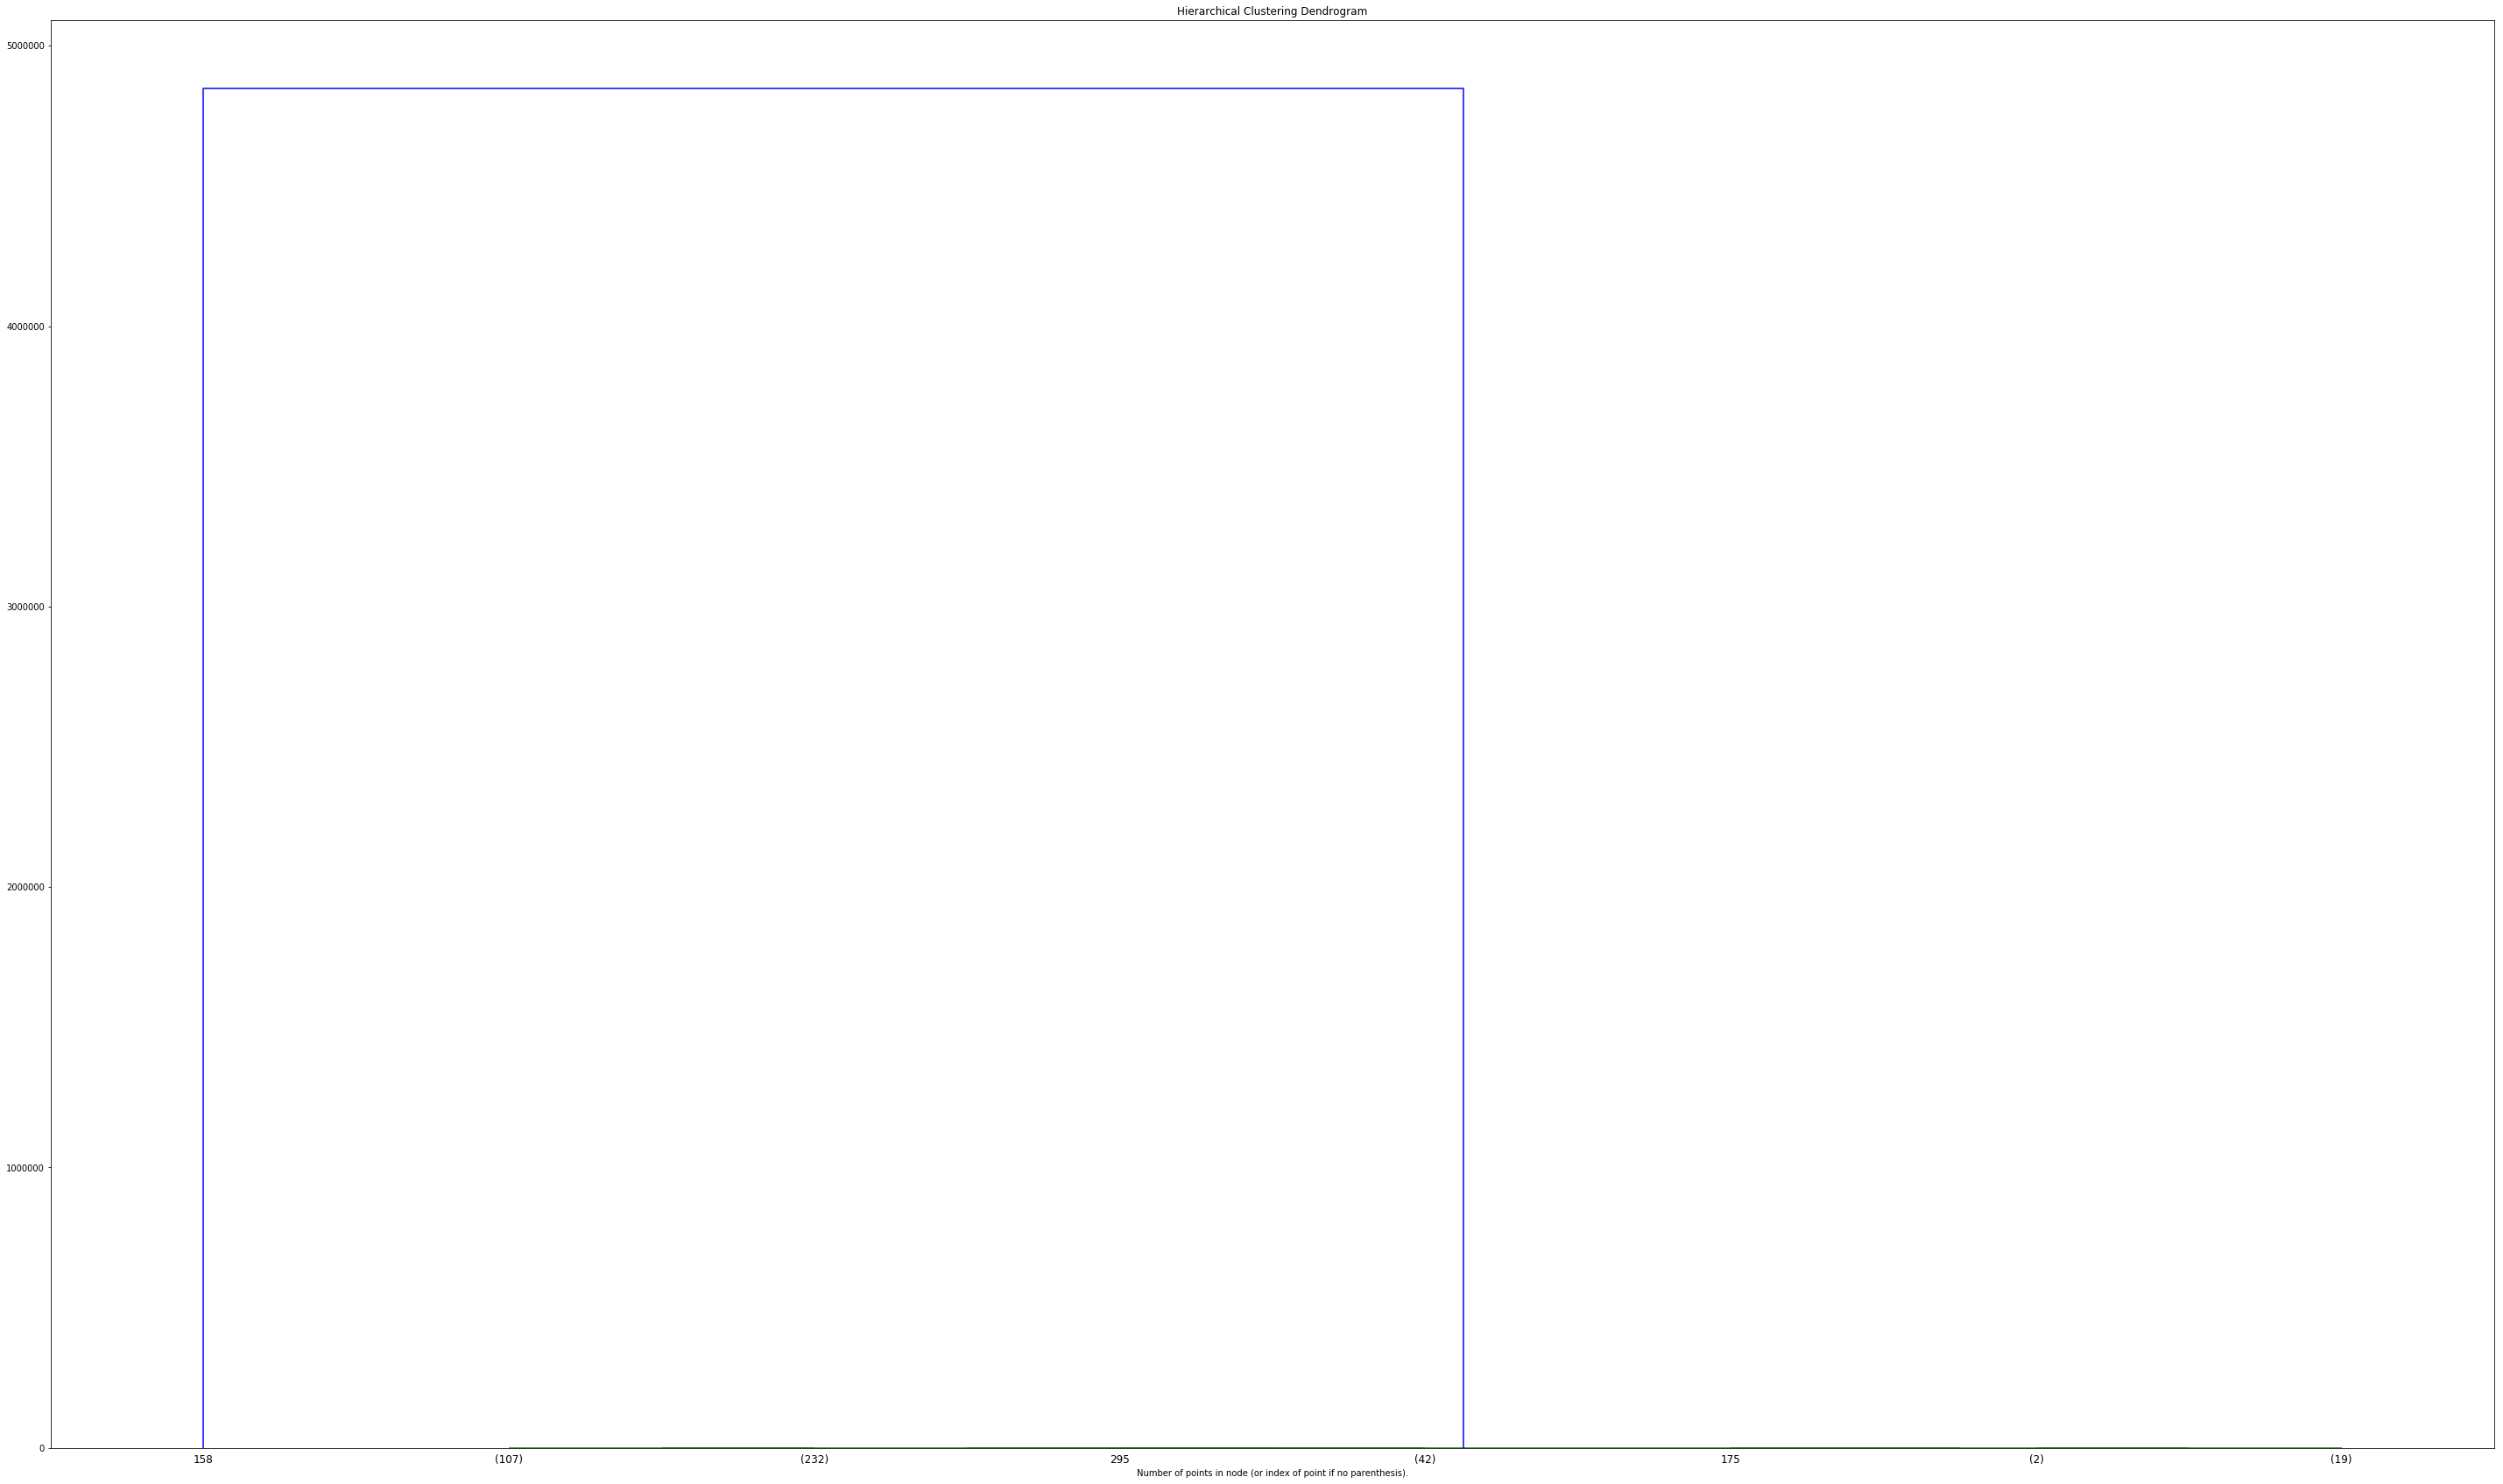

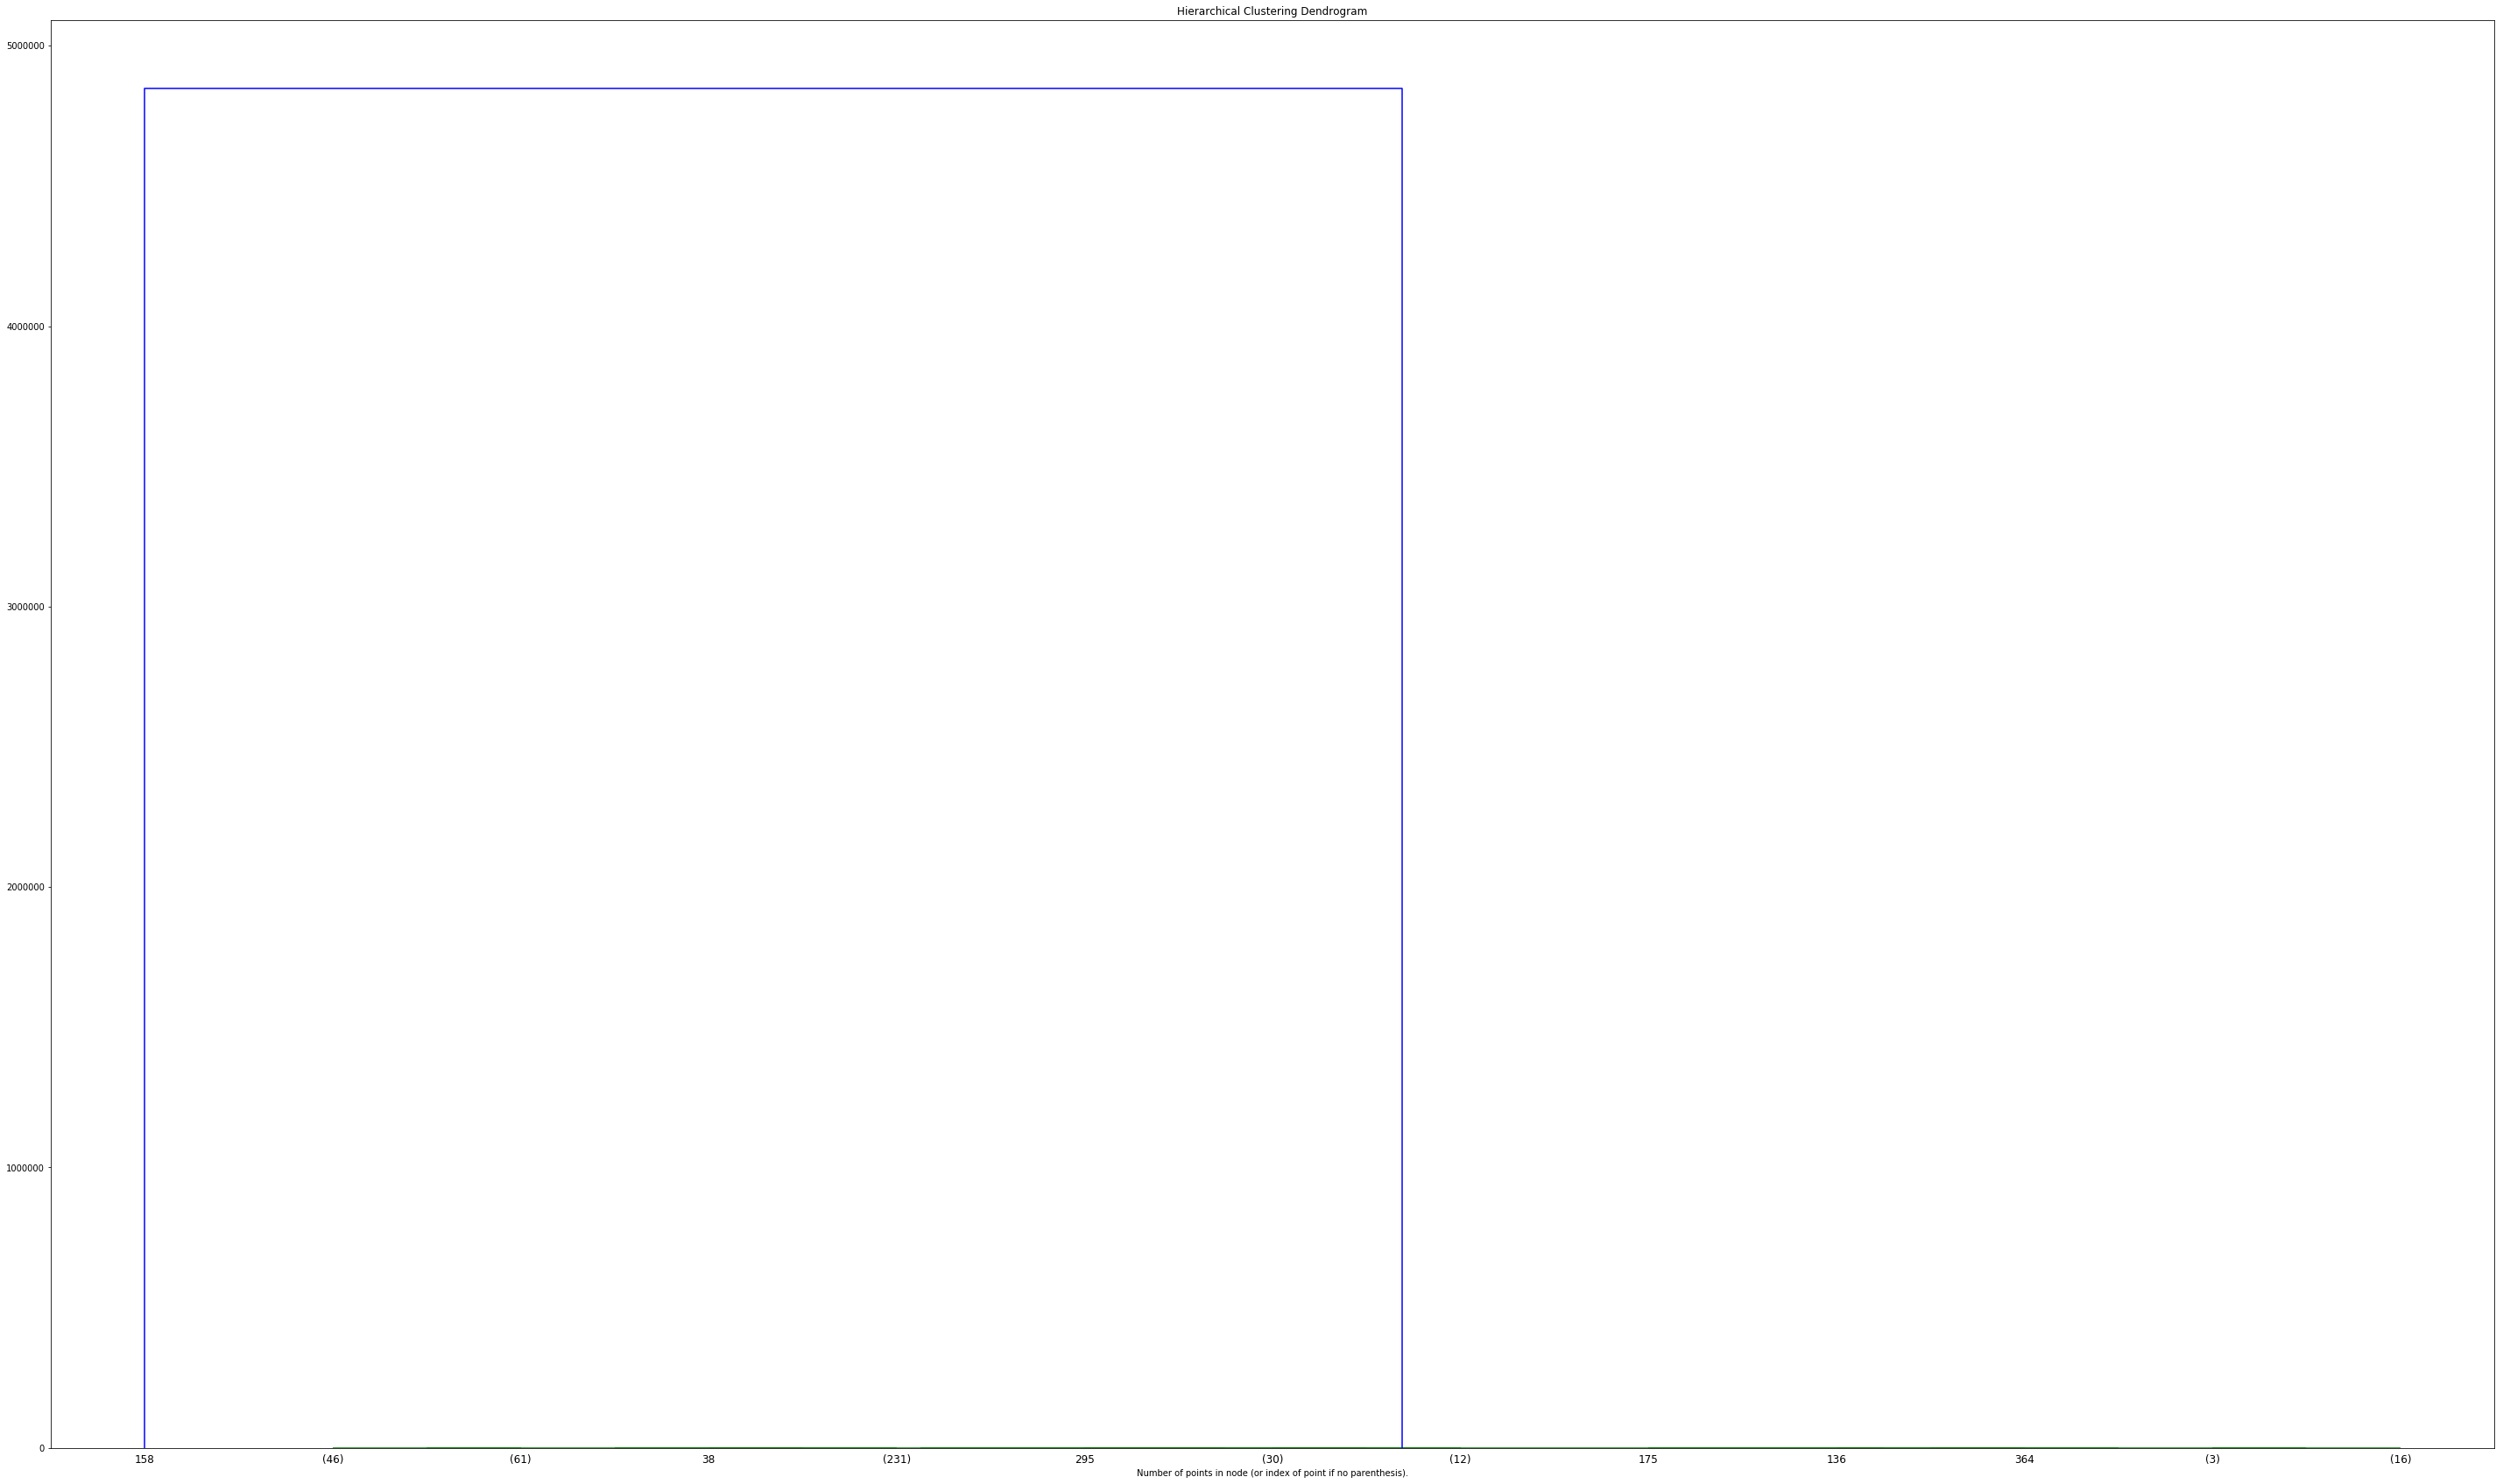

In [6]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)

for i in range(5):
    
    plt.figure(figsize=(50,30))
    plt.title('Hierarchical Clustering Dendrogram')
    # plot the top three levels of the dendrogram
    u = plot_dendrogram(model, truncate_mode='level', p=i)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.savefig('..\\reports\\figures\\dendrogram' + str(i) + '.png', dpi=100)
    plt.show()

# Визуализация кластеров TSNE

T-распределенное стохастическое вложение соседей (tSNE) - очень популярный, отмеченный наградами алгоритм уменьшения размерности. Основная сила tSNE - это визуализация кластеров: если точки данных расположены близко в многомерном пространстве, tSNE также стремится сохранить близость данных в уменьшенных измерениях. Следовательно, кластеры в исходных данных должны быть видны после уменьшения размерности.

TSNE принимает многомерные данные в качестве входных данных и возвращает представление этих данных в пространстве с уменьшенными размерами (так называемое встроенное пространство, обычно 2-мерное).

- https://distill.pub/2016/misread-tsne/
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE
- t-Distributed Stochastic Neighbor Embedding Wins Merck Viz Challenge.
http://blog.kaggle.com/2012/11/02/t-distributed-stochasticneighbor-embedding-wins-merck-viz-challenge/

In [7]:
def create_viz(transf_X, N, labels, i):
    tsne = TSNE(random_state=17, perplexity=50, n_iter=5000)
    X_embedded = tsne.fit_transform(transf_X)
    palette = sns.color_palette("bright", N)
    plt.figure(figsize=(10,10))
    plt.title('TSNE')
    sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, palette=palette)
    plt.savefig('..\\reports\\figures\\tsne_' + str(i) + '.png', dpi=100)
    plt.show()

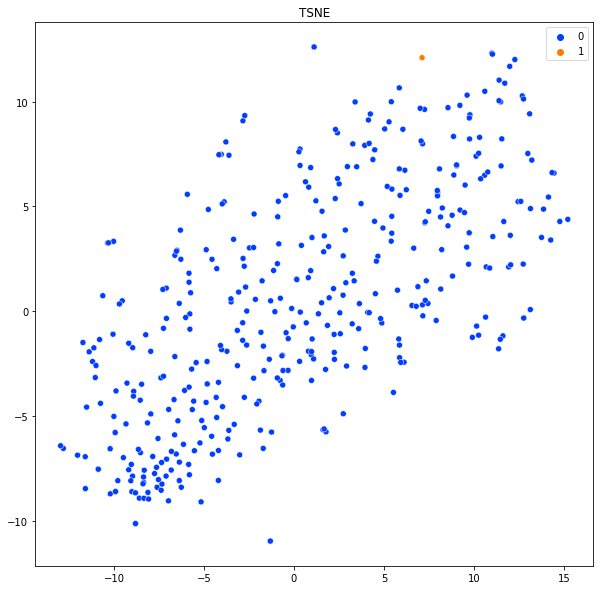

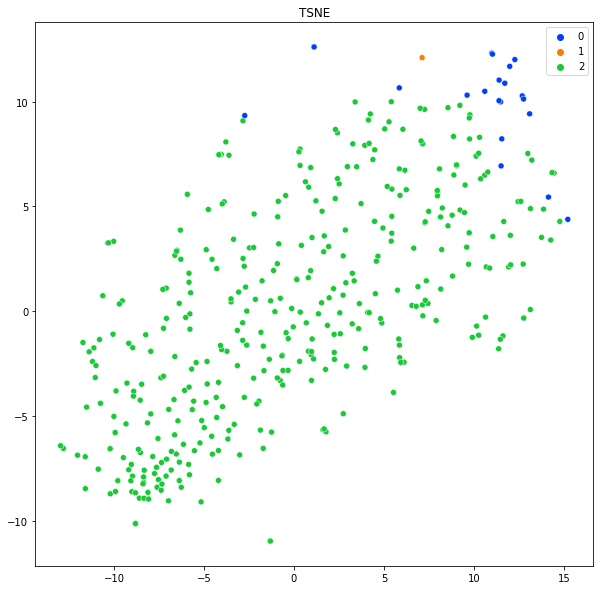

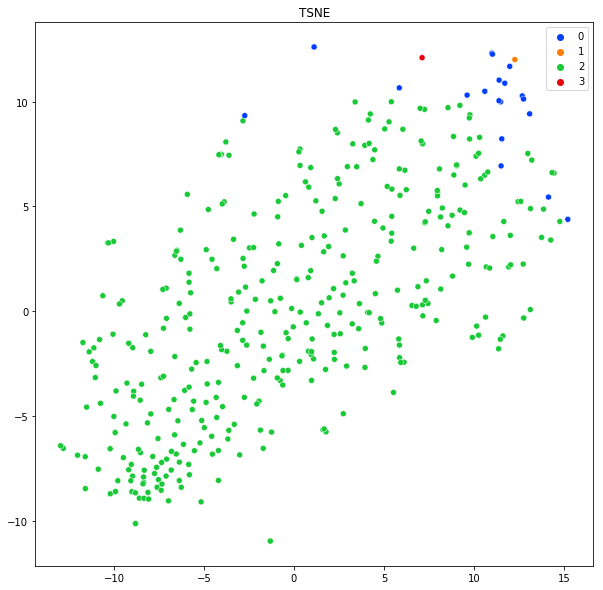

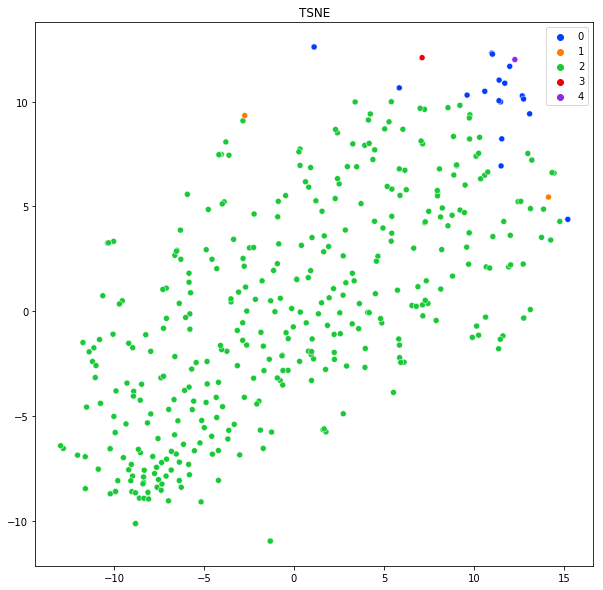

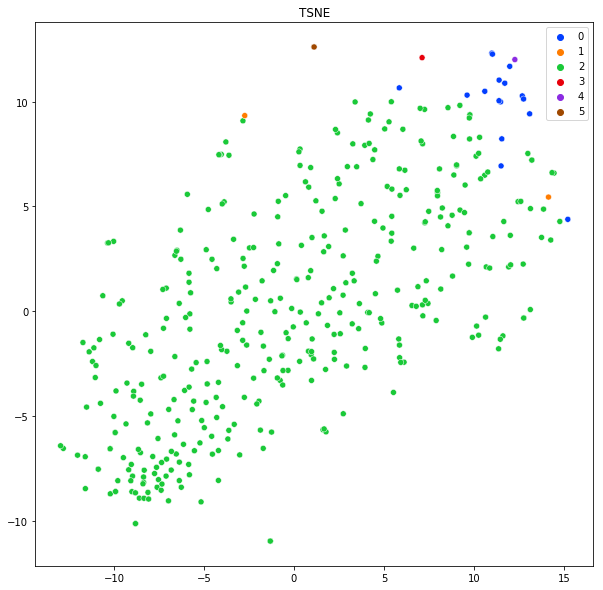

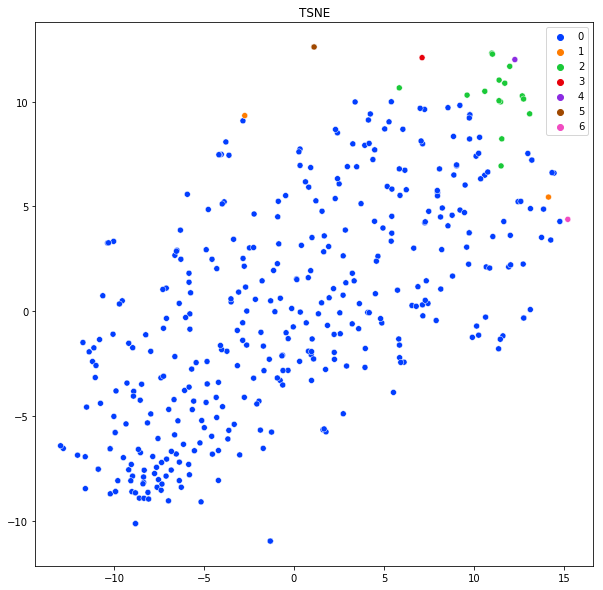

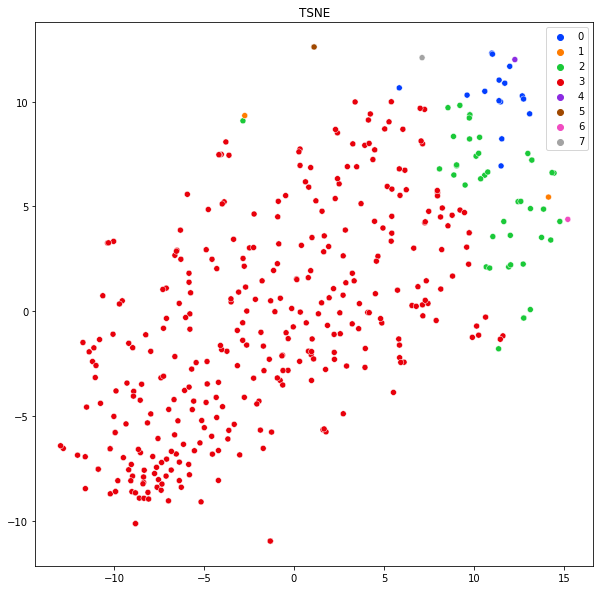

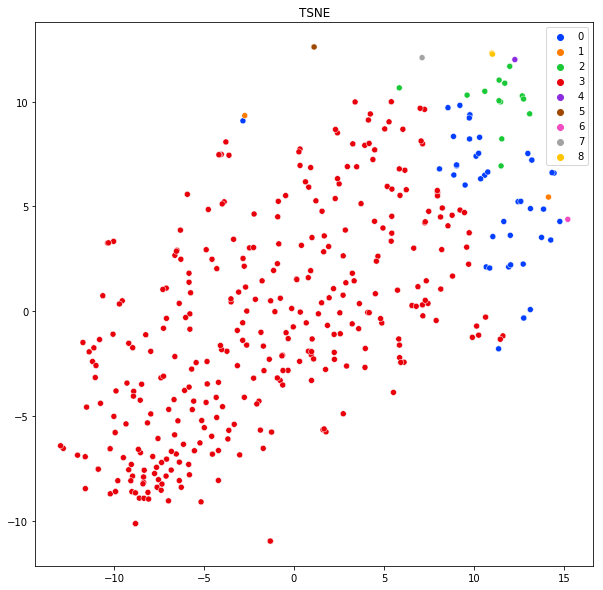

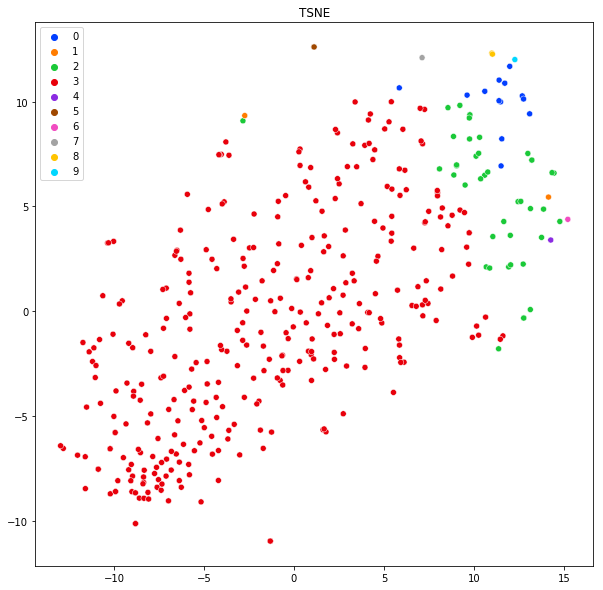

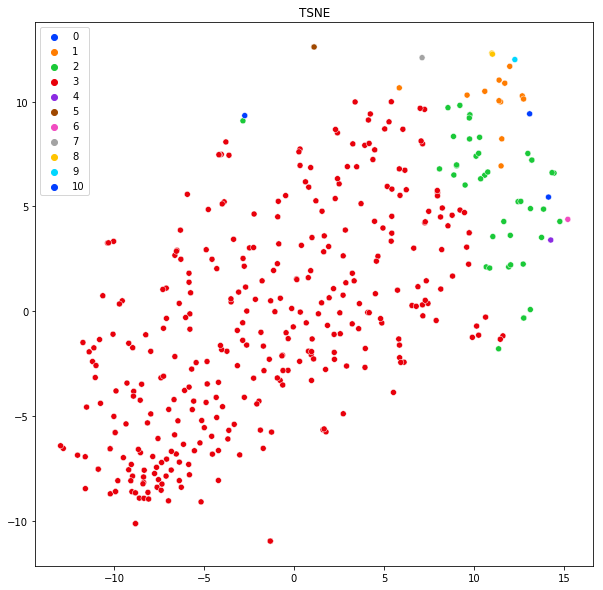

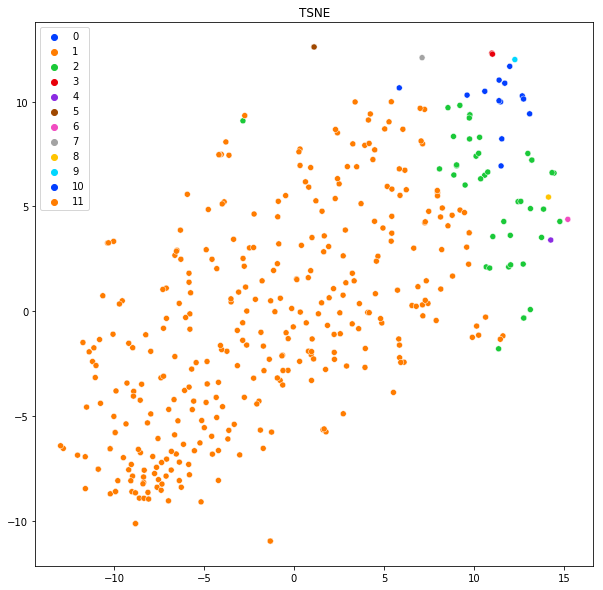

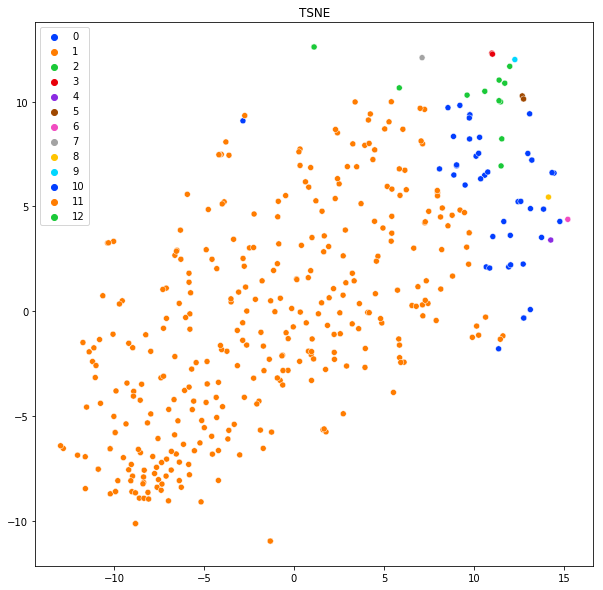

In [8]:
for i in range(2,14):
    model = AgglomerativeClustering(n_clusters=i)
    model = model.fit(X)
    create_viz(X, i, model.labels_, i)

In [9]:
dist = 1 - cosine_similarity(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(405, 2)

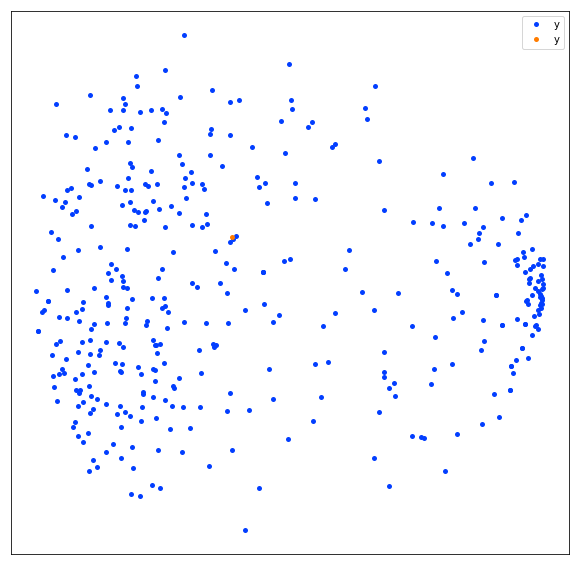

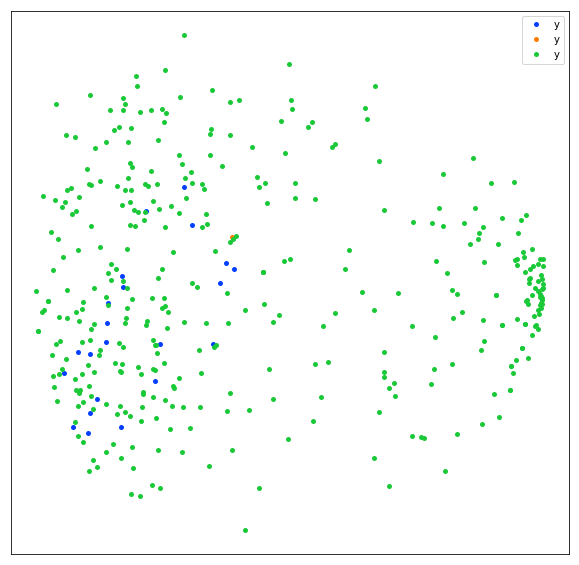

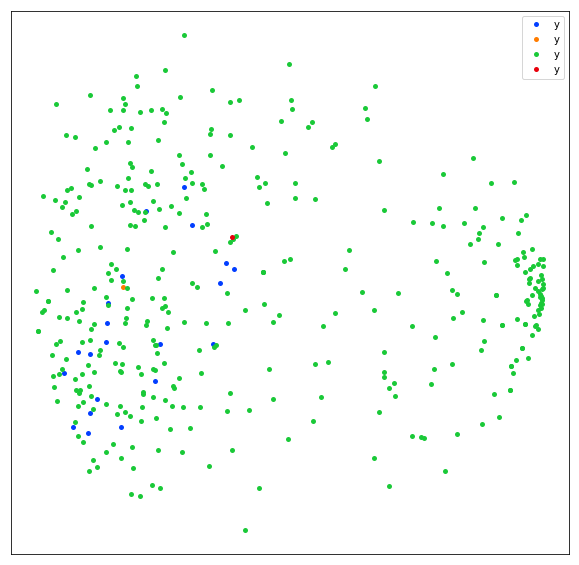

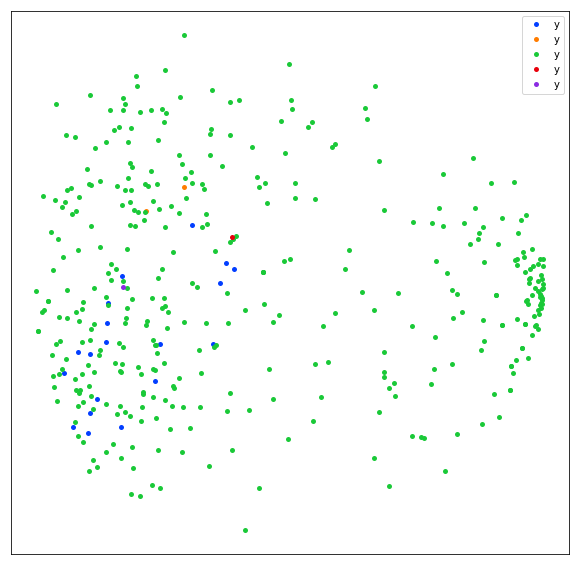

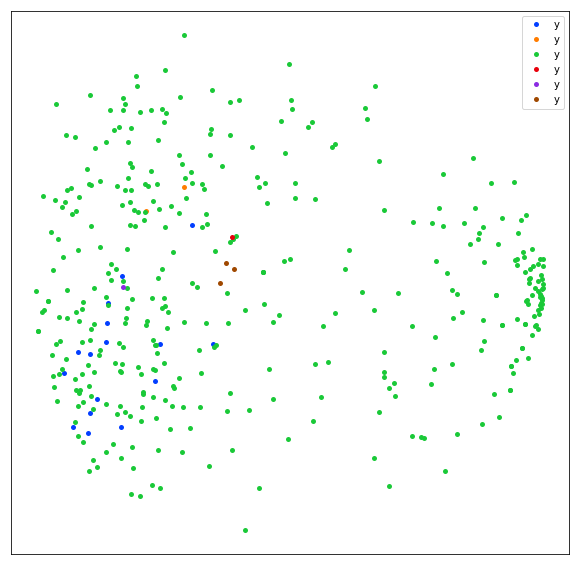

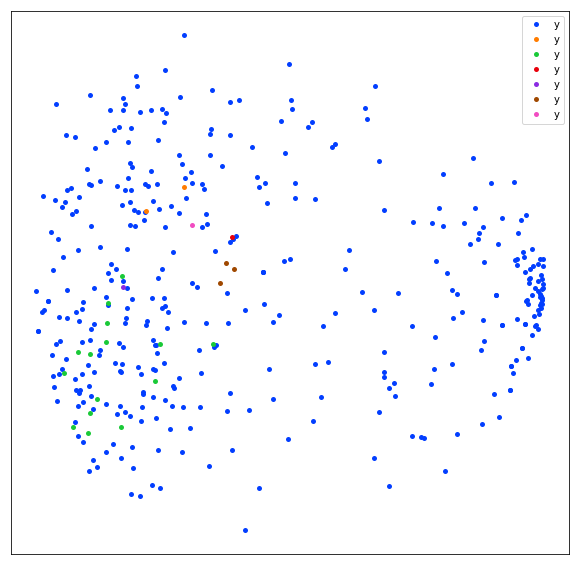

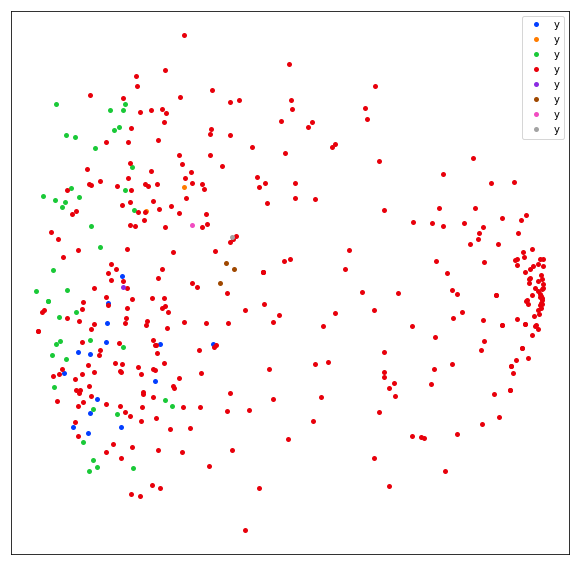

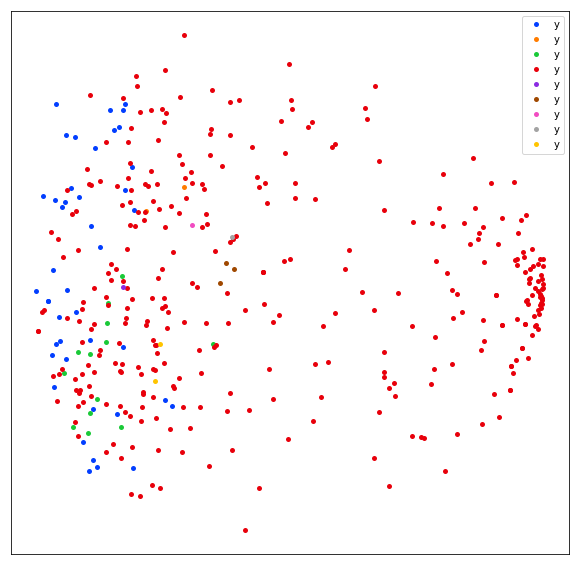

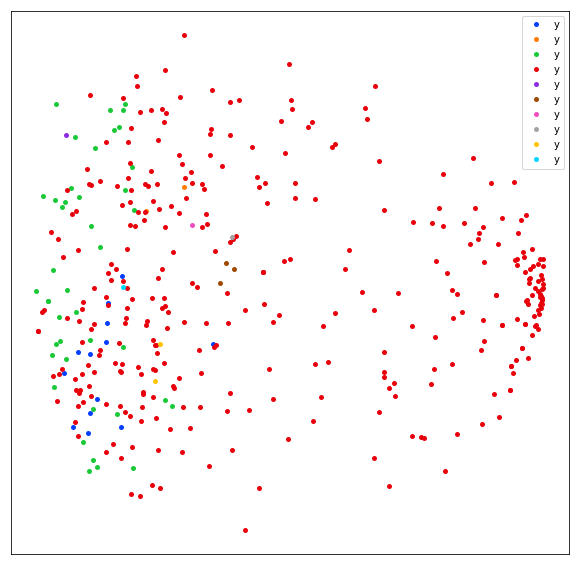

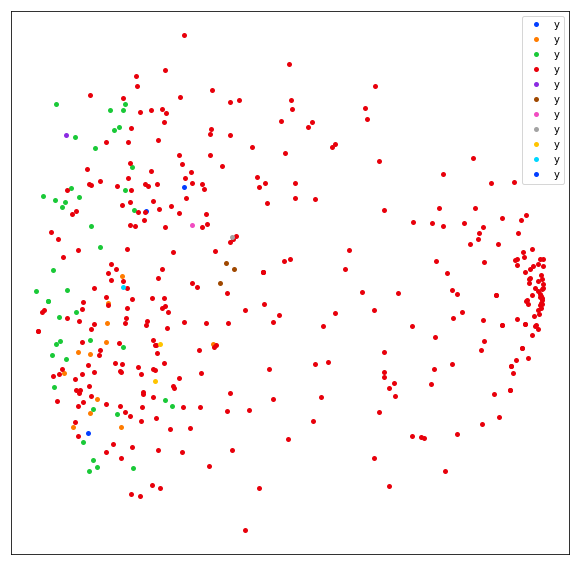

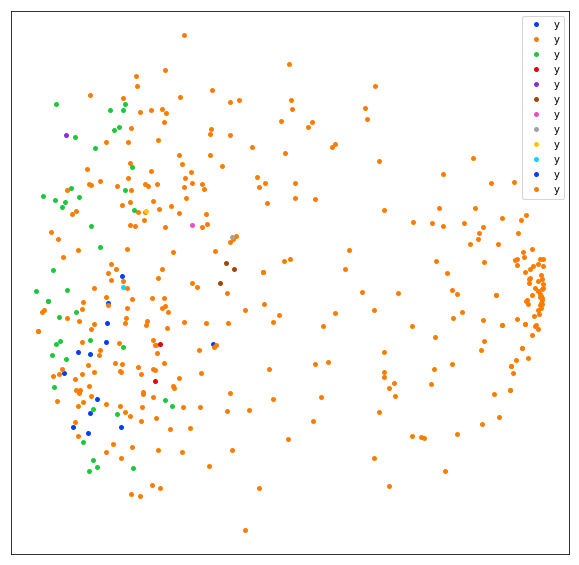

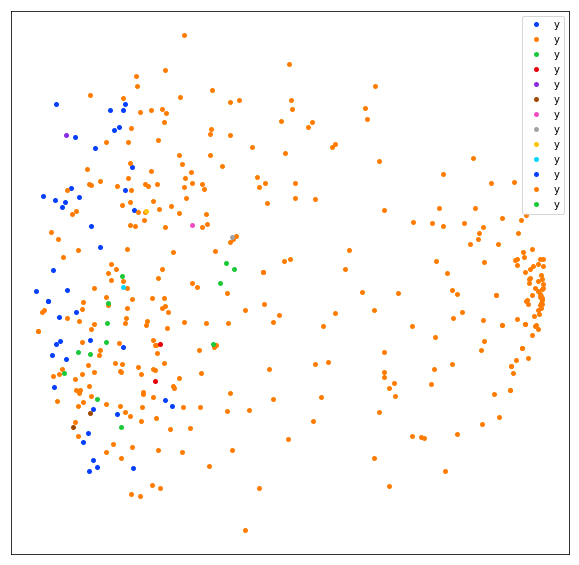

In [10]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

for i in range(2,14):
    model = AgglomerativeClustering(n_clusters=i)
    model = model.fit(X)
    
    colors = sns.color_palette("bright", i)

    df = pd.DataFrame({'x': x, 'y':y, 'label':model.labels_}) 
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(10, 10)) 

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
                color=colors[name],mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
        ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')

    ax.legend()
    plt.savefig('..\\reports\\figures\\pca_' + str(i) + '.png', dpi=100)
    plt.show()

# Метрики качества кластеризации

Важным шагом в кластерном анализе является оценка качества данной кластеризации с помощью структурных критериев качества. Меры, для оценки которых не требуется дополнительная информация (но сама кластеризация), называемые внутренними мерами, обычно используются из-за их универсальности. 

Кластерная валидация обычно использует меру оценки, фиксирующую качество кластерной структуры. Меры оценки подразделяются на неконтролируемые или внутренние меры, которые не полагаются на внешнюю информацию, и контролируемые или внешние меры, которые оценивают, насколько хорошо структура кластера соответствует структуре, определенной внешней информацией [21]. В то время как внешние меры полезны только тогда, когда доступны дополнительные внешние данные о кластерной структуре данных, внутренние меры находят применение в каждом сценарии.

## Silhouette Coefficient
The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

In [11]:
metrics.silhouette_score(X, labels, metric='euclidean')

0.9975271561222044

## Calinski-Harabasz Index
The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

In [12]:
metrics.calinski_harabasz_score(X, labels)

43901819077.41414

## Davies-Bouldin Index
Zero is the lowest possible score. Values closer to zero indicate a better partition.

In [13]:
metrics.davies_bouldin_score(X, labels)

2.52832577787602e-06

In [14]:
n_clusters = 30
silhouette_score_list = []
calinski_harabasz_score_list = []
davies_bouldin_score_list = []
for i in range(2,n_clusters):
    clustering = AgglomerativeClustering(n_clusters=i,
                                     affinity='euclidean', 
                                     memory=None, 
                                     connectivity=None, 
                                     compute_full_tree='auto', 
                                     linkage='ward', 
                                     distance_threshold=None).fit(X)
    labels = clustering.labels_
    
    silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
    calinski_harabasz_score = metrics.calinski_harabasz_score(X, labels)
    davies_bouldin_score = metrics.davies_bouldin_score(X, labels)
    
    silhouette_score_list.append(silhouette_score)
    calinski_harabasz_score_list.append(calinski_harabasz_score)
    davies_bouldin_score_list.append(davies_bouldin_score)

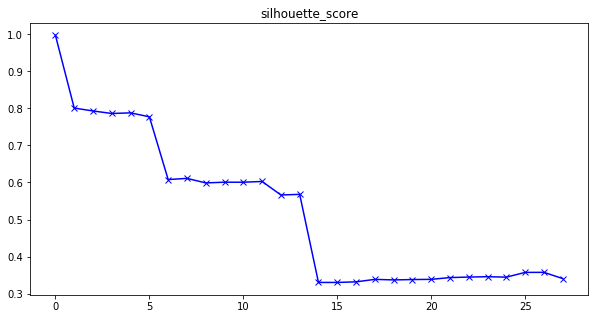

In [15]:
# The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
plt.figure(figsize=(10,5))
plt.plot(silhouette_score_list, 'bx-')
plt.title('silhouette_score')
plt.savefig('..\\reports\\figures\\silhouette_score.png', dpi=100)

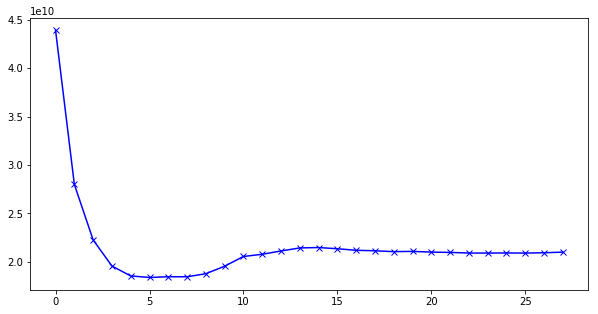

In [16]:
# The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster
plt.figure(figsize=(10,5))
plt.plot(calinski_harabasz_score_list, 'bx-')

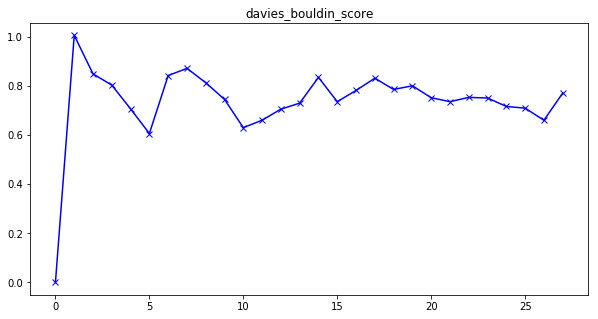

In [17]:
# Zero is the lowest possible score. Values closer to zero indicate a better partition.
plt.figure(figsize=(10,5))
plt.plot(davies_bouldin_score_list, 'bx-')
plt.title('davies_bouldin_score')
plt.savefig('..\\reports\\figures\\davies_bouldin_score.png', dpi=100)